In [1]:
# -*- coding: utf-8 -*-
#
# Birdsong classificatione in noisy environment with convolutional neural nets in Keras
# Copyright (C) 2017 Balint Czeba, Balint Pal Toth (toth.b@tmit.bme.hu)
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>. (c) Balint Czeba, Balint Pal Toth
# 
# Please cite the following paper if this code was useful for your research:
# 
# Tóth Bálint Pál, Czeba Bálint,
# "Convolutional Neural Networks for Large-Scale Bird Song Classification in Noisy Environment", 
# In: Working Notes of Conference and Labs of the Evaluation Forum, Évora, Portugália, 2016, p. 8

In [2]:
from scipy import io
from scipy.io import wavfile
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import mlab
import xmltodict
import pandas as pd
import h5py
import pickle
import gc
np.random.seed(0)

# matplotlib.use('Agg') #M: https://matplotlib.org/faq/howto_faq.html
#M: add
%matplotlib inline

plt.ioff()

In [3]:
# traiing data related paths
PATH_TRAIN_IN_16KWAVS = '../birdclef_data/TrainingSet/wav_16khz' # the location where the 16kHz resampled wavs are located
PATH_TRAIN_IN_XMLFILES = '../birdclef_data/TrainingSet/xml/' # the path where the XML meta-data files are located
PATH_TRAIN_OUT_XMLPICKLEFILE = '../birdclef_data/TrainingSet/xml_data.pickle' # the location and filename where the XML meta-data will be saved
PATH_TRAIN_OUT_HDF5 = '../birdclef_data/' # the path where preprocessed data will be saved in HDF5 format

# same as above just with test data, the wav related data will be generating in train/predict.py

#M: vvv
# PATH_TEST_IN_XMLFILES = '../birdclef_data/test/xml2015' 
PATH_TEST_IN_XMLFILES = '../birdclef_data/test/xml2016' 

PATH_TEST_OUT_XMLPICKLEFILE	= '../birdclef_data/test/xml_data.pickle'

In [4]:
# this parameter is used for preprocessing
# the number comes from the following equation: np.floor(sampling_frequency/(FFT_length-FFT_overlap))*num_of_seconds
# we use 16kHz sampling rate for the wavs, 512 FFT window length with 256 overlap and we investigate 5 seconds 
spectrogramWindowLength = int(5*np.floor(16000/(512-256))); 

In [5]:
# for path, subdirs, files in os.walk(PATH_TRAIN_IN_16KWAVS):
#     print(path[:], subdirs[:], files[:3])

In [6]:
# function to load the wave files from dirPath
#M: 在這程式裡用不到...(???) 且錯誤百出啊!!!!!!!
def loadWavs(dirPath):
    data = list()
    #M: for path, subdirs, files in os.walk(dirpath): #M: <---- 這裡參數也寫錯了!!!!
    for path, subdirs, files in os.walk(dirPath):
        for name in files:
            if (name.endswith('.wav')):
                print(os.path.join(path, name))
                tempFileName = name.split('.')[0]
                #M: tempXmlFile = open(os.path.join(xmldirpath, tempFileName + '.xml'), 'rb') #M: 沒有定義 xmldirpath????
                tempXmlFile = open(os.path.join(xmldirpath, tempFileName + '.xml'), 'r', encoding="utf-8")
                metadata = tempXmlFile.readlines()
                tempXmlFile.close()
                data.append([io.wavfile.read(os.path.join(path, name))[1], xmltodict.parse(''.join(metadata))['Audio']])
    return data;

In [7]:
# function to load corresponding XML files into a Pandas dataframe
def readXMLs(xmldirpath):
    df = pd.DataFrame()
    for path, subdirs, files in os.walk(xmldirpath):
        for name in files:
            #M: print(os.path.join(path, name))
            if (name.endswith('.xml')):
                print(os.path.join(path, name))
                #M: tempXmlFile = open(os.path.join(path, name), 'rb')
                tempXmlFile = open(os.path.join(path, name), 'r', encoding="utf-8") #M:
                metadata = tempXmlFile.readlines()
                tempXmlFile.close()
                #M: print(type(metadata),metadata) #M: debug
                df = df.append(pd.DataFrame(xmltodict.parse(''.join(metadata))['Audio'], index=['0'])).reset_index(drop=True)
    return df

In [8]:
# function to merge meta-data of the XML file
def mergeOFGS(row):
    return "{}  {} {} {}".format(row["Order"], row["Family"], row["Genus"], row["Species"])

In [9]:
# if 'x' array contains 1, this expands it inthe given directions
# used for the mask applied to the spectogram
def expandOnes(x, directions = [[-1,0], [1,0], [0,-1], [0,1]]):
    expand = np.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if (x[i,j] == 1):
                for direction in directions:
                    cx = i + direction[0]
                    cy = j + direction[1]
                    if (0 <= cx < x.shape[0] and 0 <= cy < x.shape[1]):
                        expand[cx,cy]=1;
    return x+expand;

In [10]:
# function to filter the spectogram based on the energy of the signal
#
# parameters:
#   data: audio data
#   expandByOne: if it is True, than the mask of the spectogram will be expanded in every direction
#   dropZeroColumnsPercent: determines the ratio of 0 values along the frequency axis when a timeslice is dropped
#
# return values:
#   spectogram
#   filtered spectogram

def audioToFilteredSpectrogram(data, expandByOne = True, dropZeroColumnsPercent = 0.95):
    # calculate the spectogram
    tempSpec = np.log10(mlab.specgram(data, NFFT=512, noverlap=256, Fs=16000)[0]+1)

    # drop higher frequencies
    tempSpec = tempSpec[0:200,:]
    tempSpecFiltered = np.copy(tempSpec)

    # we analize the spectogram by 20x30 sized cells
    # to achieve better accuray the size of this cell should be finetuned
    rowBorders = np.ceil(np.linspace(0,tempSpec.shape[0], 20))
    columnBorders = np.hstack((np.ceil(np.arange(0,tempSpec.shape[1], 30)), tempSpec.shape[1]))
    rowBorders = [ int(x) for x in rowBorders ]
    columnBorders = [ int(x) for x in columnBorders ]
    keepCells = np.ones((len(rowBorders)-1, len(columnBorders)-1))

    # we create a mask for the spectogram: we scan the spectogram with the 20x30 sized
    # cell and create 0 mask based on the mean and std of the spectogram calculated for the cells and rows
    for i in range(len(rowBorders)-1):
        row_mean = np.mean(tempSpec[rowBorders[i]:rowBorders[i+1],:])
        row_std = np.std(tempSpec[rowBorders[i]:rowBorders[i+1],:])

        for j in range(len(columnBorders)-1):
            cell_mean = np.mean(tempSpec[rowBorders[i]:rowBorders[i+1],columnBorders[j]:columnBorders[j+1]])
            cell_max_top10_mean = np.mean(np.sort(tempSpec[rowBorders[i]:rowBorders[i+1],columnBorders[j]:columnBorders[j+1]], axis=None)[-10:])

            if (cell_mean < 0 or ((cell_max_top10_mean) < (row_mean + row_std)*1.5)):
                keepCells[i,j]=0

    # expand by ones (see above)
    if expandByOne:
        keepCells = expandOnes(keepCells)

    # apply the mask to the spectogram
    for i in range(keepCells.shape[0]):
        for j in range(keepCells.shape[1]):
            if not keepCells[i,j]:
                tempSpecFiltered[rowBorders[i]:rowBorders[i+1],columnBorders[j]:columnBorders[j+1]] = 0

    # drop zero columns
    # the amount of zero values along axis 0 (frequency) is calculated for every column (timeslice)
    # and it is dropped, if the number of zero values is higher than the dropZeroColumnsPercent 
    # eg. dropZeroColumnsPercent=0.95, than a column (timeslice) is dropped, if more than 95% of the values (frequencies) is 0
    tempSpecFilteredBackup = np.copy(tempSpecFiltered)
    tempSpecFiltered = np.delete(tempSpecFiltered, np.nonzero((tempSpecFiltered==0).sum(axis=0) > tempSpecFiltered.shape[0]*dropZeroColumnsPercent), axis=1)

    # if every row was 0 than use the backed up spectogram
    if tempSpecFiltered.shape[1] == 0:
        tempSpecFiltered = tempSpecFilteredBackup

    return tempSpec, tempSpecFiltered;

In [11]:
# function to return most common classes in the dataset
def getMostCommon(df, N=10):
    from collections import Counter
    c = Counter(df["ClassId"])
    mostCommon = c.most_common(N)
    df_mostCommon = pd.DataFrame()
    for item in mostCommon:
        df_mostCommon = df_mostCommon.append(df[df["ClassId"] == item[0]], ignore_index=True)
    df_mostCommon.reset_index(drop=True)
    return df_mostCommon;

In [12]:
# function to return data inbetween minQuality and maxQuality
def filterByQuality(df, minQuality=0, maxQuality=5):
    df_filtered = pd.DataFrame()
    for quality in range(minQuality, maxQuality+1):
        df_filtered = df_filtered.append(df[df["Quality"] == str(quality)], ignore_index=True)
    df_filtered.reset_index(drop=True, inplace=True)
    return df_filtered;   

In [13]:
# function to remove samples where background species exist
def removeSamplesWithBackgroundSpecies(df):
    return df[df.BackgroundSpecies.isnull()]

In [14]:
# create onehot encoding for order, family, genus, specie
def getOneHotOFGS(df):
    from sklearn.preprocessing import LabelBinarizer
    lb = LabelBinarizer()
    lb.fit(df["OFGS"])
    return ( lb, lb.transform(df["OFGS"]) )

In [15]:
# create onehot encoding for classid
def getOneHotClassId(df):
    from sklearn.preprocessing import LabelBinarizer
    lb = LabelBinarizer()
    lb.fit(df["ClassId"])
    return ( lb, lb.transform(df["ClassId"]) )

In [16]:
# bulk processing of wav files in path
#
# parameters:
#   path        the source path
#   filenames   the filenames in the path
#   dontFilter  does not filter the spectogram if it is set to True
#
# return value:
#   specotogram data of multiple files

def wavsToSpectrogramByList(path, filenames, dontFilter=False):
    print("wavsToSpectrogramByList...")
    data=list()
    for filename in filenames:
        print('\r    Processing {}'.format(os.path.join(path, filename))),
        (tempSpecUnfiltered,tempSpecFiltered) = audioToFilteredSpectrogram(io.wavfile.read(os.path.join(path, filename))[1], expandByOne=True)
        if (not dontFilter):
            data.append(tempSpecFiltered)
        else:
            data.append(tempSpecUnfiltered)
    print("\nwavsToSpectrogramByList finished")
    return data;

In [17]:
# function to create training data from the list generated by wavsToSpectogramByList function
#
# parameters:
#   slist      the spectogram list generated by wavsToSpectogramByList function
#   labels     contain the class labels of the corresponding spectograms
#   N          (1*44100)/(1024-512)=86
#   filenames  filenames to return
#   classIds   class IDs to return
#
# return values
#   X          the constructed input
#   y          the constructed output
#   fn         filenames
#   cIds       class IDs
#
  
def spectrogramListToT4(slist, labels=None, N=spectrogramWindowLength, filenames=None, classIds=None): 
    print("SpectrogramListToT4...")

    rows = len(slist[0])
    X = np.empty((0,1,rows,N))
    y = []
    fn = []
    cIds = []

    # process all spectograms
    for i in range(len(slist)):
        print('\r    Processing no. %d / %d' % (i, len(slist)))
        ranges = np.hstack((np.arange(0, len(slist[i][0]), N), len(slist[i][0])))

        for j in range(len(ranges)-1):
            # variable contains
            tempSpec = np.empty((1,rows,N))

            if (len(slist[i][0]) < N): # if data is shorter than N than fill up with zeros
                tempSpec[0] = np.hstack((slist[i],np.zeros((rows, N-len(slist[i][0])))))
            elif (ranges[j+1]-ranges[j] < N): # last element
                tempSpec[0] = slist[i][:,-N:]
            else: # other part of the spectrum
                tempSpec[0] = slist[i][:,ranges[j]:ranges[j+1]]

            X = np.vstack((X,[tempSpec]))

            if labels is not None:
                y.append(labels[i])
            if filenames is not None:
                fn.append(filenames[i])
            if classIds is not None:
                cIds.append(classIds[i])

    print("SpectrogramListToT4 finished")
    return X, y, fn, cIds

In [18]:
# calculates the standard scaler coefficients of the input data for 0 mean and 1 variance
#
# parameters
#   numberOfFiles   the number of files to process (we assume that the mean and variance will be similar in case
#                   of a subset of the training data and we don't have to process the whole database
#   wavdirpath      the path that contains the wavs (sampled at 16kHz)
#   xmlpicklepath   the path and filename that contains the XML file for training (xml_data.pickle)
#
# return values
#   scaler
#   spectogramData
#

def generateScaler(numberOfFiles=100, wavdirpath=PATH_TRAIN_IN_16KWAVS, xmlpicklepath=PATH_TRAIN_OUT_XMLPICKLEFILE, todirrootpath=PATH_TRAIN_OUT_HDF5):
    if not os.path.exists(todirrootpath):
        os.makedirs(todirrootpath)

    import pickle    
    df = pd.read_pickle(xmlpicklepath) # contains the metadata
    print("Metadata loaded")

    # Shuffle rows
    df = df.iloc[np.random.permutation(len(df))]
    df.reset_index(drop=True, inplace=True)
    print("Metadata shuffled")
    
    # Calculate spectograms
    spectrogramData = wavsToSpectrogramByList(wavdirpath, df.FileName[:numberOfFiles], dontFilter=False)
    print("Spectrograms done.")

    print('Building scaler...')
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    # calculate the scaler variables spectogram by spectogram
    for sData in spectrogramData:
        scaler.partial_fit(sData.reshape(-1,1))

    # filename where we save the scaler
    saveTo = os.path.join(todirrootpath,"standardScaler_{}.pickle".format(numberOfFiles))
    from sklearn.externals import joblib
    import pickle
    pickle.dump(scaler, open(saveTo, 'wb'))
    print('Scaler saved to: {}'.format(saveTo))
    
    return scaler, spectrogramData

In [19]:
# ?h5py.File

In [20]:
# function that constructs training data 
#
# parameters:
#   N                   number of most classes to take into account 
#   wavdirpath          path of the wave files (16kHz)
#   xmlpicklepath       the path and filename that contains the XML file for training (xml_data.pickle)
#   todirrootpath       path were to save the training data
#
# return values:
#   X,y,fn              for debuging purposes
#

def processNMostCommon(N=3, wavdirpath=PATH_TRAIN_IN_16KWAVS, xmlpicklepath=PATH_TRAIN_OUT_XMLPICKLEFILE, todirrootpath=PATH_TRAIN_OUT_HDF5):
    global spectrogramWindowLength

    print('spectrogramHeight = 200')
    
    if not os.path.exists(todirrootpath):
        os.makedirs(todirrootpath)
        
    spectrogramHeight = 200

    f = h5py.File(os.path.join(todirrootpath,"data_top{}_nozero.hdf5".format(N)), mode='w')
    dsetX = f.create_dataset('X', (0,1,spectrogramHeight,spectrogramWindowLength), maxshape=(None, 1,spectrogramHeight,spectrogramWindowLength))
    dsety = f.create_dataset('y', (0,N), maxshape=(None,N))
    dsetMediaId = f.create_dataset('MediaId', (0,1), maxshape=(None,1))
    #M:    dsetClassId = f.create_dataset('ClassId', (0,1), maxshape=(None,1), dtype=h5py.special_dtype(vlen=unicode))
    dsetClassId = f.create_dataset('ClassId', (0,1), maxshape=(None,1), dtype=h5py.special_dtype(vlen=str))
    
    import pickle
    print('read the metadata', 'pd.read_pickle(xmlpicklepath)')
    df = pd.read_pickle(xmlpicklepath) # read the metadata

    # if we would like to keep recordings with a given quality than we can do it here by uncommenting the next line
    #df = filterByQuality(df, 0, 3)

    df["OFGS"] = df.apply(mergeOFGS, axis=1) # merge Order, Family, Genus, Species
    df_mc = getMostCommon(df, N) # get N most common classes from the dataset
    df = None # let GC free up some memory
    print("Metadata loaded")

    # Shuffle rows
    df_mc = df_mc.iloc[np.random.permutation(len(df_mc))]
    df_mc.reset_index(drop=True, inplace=True)
    (lb,binaryLabels) = getOneHotClassId(df_mc) # generate one-hot labels
    pickle.dump(lb, open(os.path.join(todirrootpath,"labelBinarizer_top{}.pickle".format(N)), 'wb'))

    # process the selected files of top N classes and save the data into HDF5
    fileRanges = np.hstack((np.arange(0, len(df_mc), 30), len(df_mc)))
    for i in range(len(fileRanges)-1):
        tempSG = wavsToSpectrogramByList(wavdirpath, df_mc.FileName[fileRanges[i]: fileRanges[i+1]], dontFilter=False)
        X, y, fn, cIds = spectrogramListToT4(tempSG, \
                            binaryLabels[fileRanges[i]: fileRanges[i+1]], \
                            filenames = df_mc.MediaId[fileRanges[i]: fileRanges[i+1]].values, N=spectrogramWindowLength, \
                            classIds = df_mc.ClassId[fileRanges[i]: fileRanges[i+1]].values) #convert to t4
        pre_len = dsetX.shape[0]
        add_len = X.shape[0]
        dsetX.resize(pre_len+add_len, axis=0)
        dsety.resize(pre_len+add_len, axis=0)
        dsetMediaId.resize(pre_len + add_len, axis=0)
        dsetClassId.resize(pre_len + add_len, axis=0)
        dsetX[pre_len:pre_len+add_len,:,:,:] = X
        dsety[pre_len:pre_len+add_len,:] = y
        dsetMediaId[pre_len:pre_len+add_len,:] = np.transpose([[int(i) for i in fn]])
        dsetClassId[pre_len:pre_len+add_len,:] = np.transpose([[s.encode('utf8') for s in cIds]])
        f.flush()
        
    f.close
    return (X,y,fn) # return last batch for debug purposes

In [21]:
print("== Generating training data ==")
print("Reading XML files and generating pickle file")
df_xml = readXMLs(PATH_TRAIN_IN_XMLFILES) # read XML files with meta-data
df_xml.to_pickle(PATH_TRAIN_OUT_XMLPICKLEFILE) # save the loaded meta-data into a pickle file with all the informatio

== Generating training data ==
Reading XML files and generating pickle file
../birdclef_data/TrainingSet/xml/LIFECLEF2015_BIRDAMAZON_XC_WAV_RN16012.xml
../birdclef_data/TrainingSet/xml/LIFECLEF2015_BIRDAMAZON_XC_WAV_RN16234.xml
../birdclef_data/TrainingSet/xml/LIFECLEF2015_BIRDAMAZON_XC_WAV_RN16612.xml
../birdclef_data/TrainingSet/xml/LIFECLEF2015_BIRDAMAZON_XC_WAV_RN16065.xml
../birdclef_data/TrainingSet/xml/LIFECLEF2015_BIRDAMAZON_XC_WAV_RN16835.xml
../birdclef_data/TrainingSet/xml/LIFECLEF2015_BIRDAMAZON_XC_WAV_RN16832.xml
../birdclef_data/TrainingSet/xml/LIFECLEF2015_BIRDAMAZON_XC_WAV_RN16453.xml
../birdclef_data/TrainingSet/xml/LIFECLEF2015_BIRDAMAZON_XC_WAV_RN16545.xml
../birdclef_data/TrainingSet/xml/LIFECLEF2015_BIRDAMAZON_XC_WAV_RN16338.xml
../birdclef_data/TrainingSet/xml/LIFECLEF2015_BIRDAMAZON_XC_WAV_RN16876.xml
../birdclef_data/TrainingSet/xml/LIFECLEF2015_BIRDAMAZON_XC_WAV_RN16982.xml
../birdclef_data/TrainingSet/xml/LIFECLEF2015_BIRDAMAZON_XC_WAV_RN16693.xml
../birdclef_

In [22]:
#M: for tracking...
df_xml.to_csv('../birdclef_data/TrainingSet/xml_data.csv')

In [23]:
df_xml.head(1)

,MediaId,FileName,ClassId,Date,Time,Locality,Latitude,Longitude,Elevation,Author,...,Comments,Quality,Year,BackgroundSpecies,Order,Family,Genus,Species,Sub-species,VernacularNames
0,16012,LIFECLEF2015_BIRDAMAZON_XC_WAV_RN16012.wav,cpzzjy,2009-02-18,07:30,"Barinitas, Bolivar, Barinas",8.8863,-70.4877,1400,Fernand DEROUSSEN,...,bird-seen:yesplayback-used:no,1,BirdCLEF2015,None,Passeriformes,Mimidae,Mimus,gilvus,None,Tropical Mockingbird


In [24]:
len(df_xml['ClassId'].unique())

468

In [ ]:
print("Process wav files and save them into HDF5")

# (X, y, fn) = processNMostCommon(999, wavdirpath=PATH_TRAIN_IN_16KWAVS, xmlpicklepath=PATH_TRAIN_OUT_XMLPICKLEFILE, todirrootpath=PATH_TRAIN_OUT_HDF5) # processes the most common 999 species (so the whole dataset)
(X, y, fn) = processNMostCommon(468, wavdirpath=PATH_TRAIN_IN_16KWAVS, xmlpicklepath=PATH_TRAIN_OUT_XMLPICKLEFILE, todirrootpath=PATH_TRAIN_OUT_HDF5)
# processes the most common 999 species (so the whole dataset)
# print("Generating scaler")
# scaler, data	= generateScaler(5000, wavdirpath=PATH_TRAIN_IN_16KWAVS, xmlpicklepath=PATH_TRAIN_OUT_XMLPICKLEFILE, todirrootpath=PATH_TRAIN_OUT_HDF5) # calculates and saves the standard scaler based on 5000 wav files

In [26]:
print(type(X), X.shape)
print(type(y), len(y), y[:3], len(y[0]))
print(type(fn), fn[:10])


<class 'numpy.ndarray'> (182, 1, 200, 310)
<class 'list'> 182 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 

In [27]:
#M: 先 bypass 不跑測試集!!!!
# print("== Generating test data ==")
# print("Reading XML files and generating pickle file")
# df_xml = readXMLs(PATH_TEST_IN_XMLFILES) # read XML files with meta-data
# df_xml.to_pickle(PATH_TEST_OUT_XMLPICKLEFILE) # save the loaded meta-data into a pickle file with all the informatio

In [28]:
#M: 重改原來的 loadWavs 程式, 一次只 load 一個檔案
def loadWav(fileName):
    data = list()
    tempFileName = fileName.split('.')[0]
    tempXmlFile = open(PATH_TRAIN_IN_XMLFILES + tempFileName + '.xml', 'r', encoding="utf-8")
    metadata = tempXmlFile.readlines()
    tempXmlFile.close()
    data.append([io.wavfile.read(os.path.join(PATH_TRAIN_IN_16KWAVS, fileName))[1], xmltodict.parse(''.join(metadata))['Audio']])
    return data;

In [29]:
#M: 測試讀入第一個 wav 檔
data = loadWav('LIFECLEF2015_BIRDAMAZON_XC_WAV_RN16000.wav')
data

[[array([ 21, -20, -25, ...,   0,   0,   0], dtype=int16),
  OrderedDict([('MediaId', '16000'),
               ('FileName', 'LIFECLEF2015_BIRDAMAZON_XC_WAV_RN16000.wav'),
               ('ClassId', 'bjsvvq'),
               ('Date', '2006-12-00'),
               ('Time', '?:?'),
               ('Locality', 'Cerro Humo, Paria Peninsula, Sucre'),
               ('Latitude', '10.7073'),
               ('Longitude', '-62.6284'),
               ('Elevation', '1500'),
               ('Author', 'David Edwards'),
               ('AuthorID', 'AFEHYCAHZR'),
               ('Content', 'song'),
               ('Comments', None),
               ('Quality', '1'),
               ('Year', 'BirdCLEF2015'),
               ('BackgroundSpecies', None),
               ('Order', 'Passeriformes'),
               ('Family', 'Furnariidae'),
               ('Genus', 'Synallaxis'),
               ('Species', 'cinnamomea'),
               ('Sub-species', None),
               ('VernacularNames', 'Stripe-breasted 

Processing LIFECLEF2015_BIRDAMAZON_XC_WAV_RN16000.wav
  data_item[0]=[ 21 -20 -25 ...,   0   0   0], len(data_item[0]=1635841)


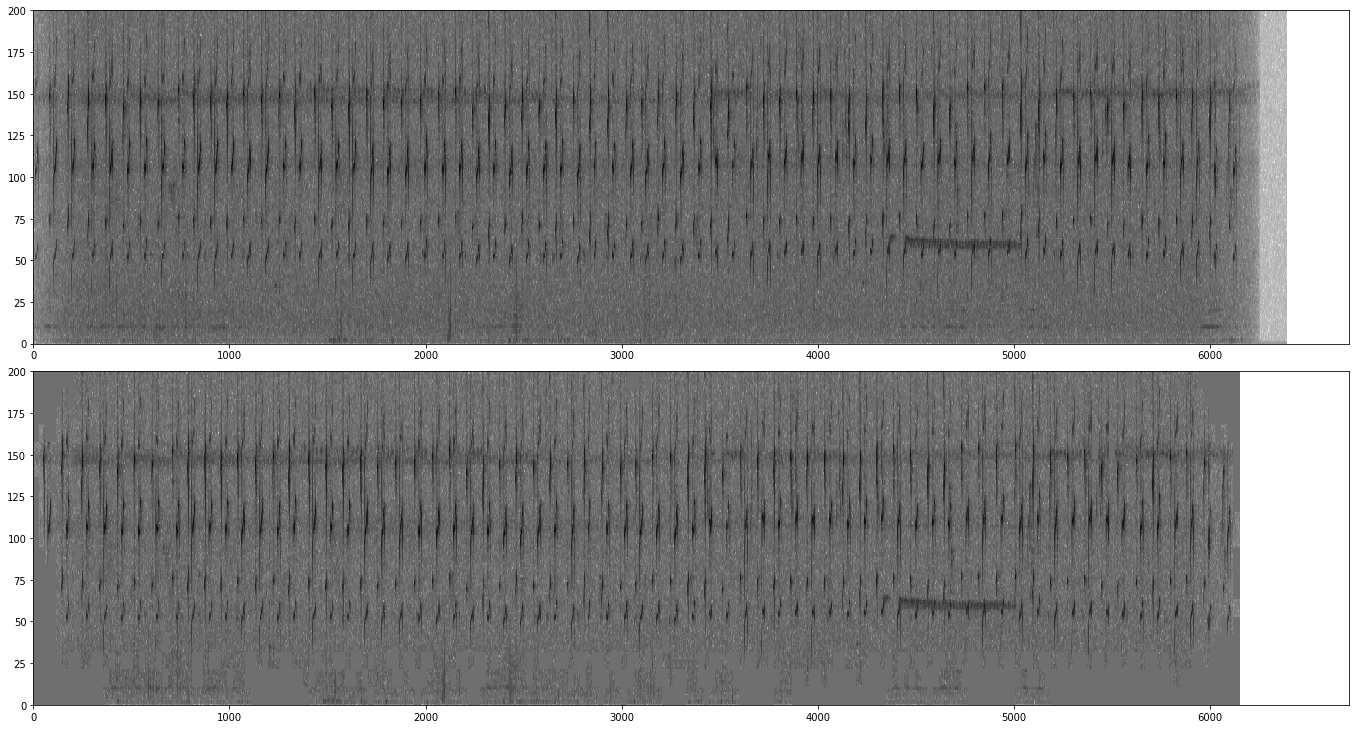

In [30]:
# if os.path.exists('../figures/') is False:
#     os.mkdir('../figures/') #M:
for data_item in data:
    print("Processing {}".format(data_item[1]['FileName']))
    print('  data_item[0]={}, len(data_item[0]={})'.format(data_item[0], len(data_item[0])))
    tempSpec, tempSpecFiltered = audioToFilteredSpectrogram(data_item[0])
    plt.ioff()
    fig = plt.figure(figsize=(19,10))
#     plt.hold(False)
    ax1=plt.subplot(211)
    plt.tight_layout()
    plt.pcolormesh(tempSpec, cmap=plt.cm.binary)
    plt.subplot(212, sharex=ax1, sharey=ax1)
    plt.pcolormesh(tempSpecFiltered, cmap=plt.cm.binary)
    plt.show()
#     fig.savefig('../figures/' + data_item[1]['FileName'][:-4] + '.png', transparent = True)
    plt.close(fig)

### The End!